## Calc de gradient vector for a cavity. 

### Desplazamientos entre -2 y 2

In [2]:
using DataFrames
using Gadfly
using Cairo
using MIToS.PDB
using Distributions
set_default_plot_size(40cm, 14cm)

In [3]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [4]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [5]:
function read_ptraj_modes(file, modes_elements, norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 2 methods)

In [6]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [7]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [8]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
prt_name = "1prn"
pdb_filename = string("/home/german/labo/16/exs/cavities/bu/avg_", prt_name, ".pdb")
pdb_pdb = read(pdb_filename, PDBFile, group="ATOM");

# Obtengo el número de átomos de c/ residuo
for i=1:length(pdb_pdb)
    push!(natom_res, length(pdb_pdb[i]))
end
shift!(natom_res)

# Obtengo el nro de aa's
aa = length(pdb_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn = Array{Float64}(aa3-6);
vol_ndd = Array{Float64, 2}(0, 2);
factorr = Array{Float64}(aa3-6);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_prt, evals_prt = read_ptraj_modes("/home/german/labo/16/exs/run/1prn/pca/modes_1prn", aa3);

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/exs/cavities/1prn/"
# Archivos de config de ANA
conf_prt_whole = "/home/german/labo/16/exs/cavities/bu/1prn.cfg"

"/home/german/labo/16/exs/cavities/bu/1prn.cfg"

### Desplazo la estructura original a lo largo de cada modo. Los modos son normalizados y luego multiplicados por -2 y 2; y así obtener distintos desplazamientos. Creando así 2 sets, c/u de 339 estructuras desplazadas (1 por c/ modo)

In [9]:
constant = 3
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-2 2]
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_prt[i*3-2, j]
            modo_sum[i, 2] = modes_prt[i*3-1, j]
            modo_sum[i, 3] = modes_prt[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factorr[j] = magnitude * constant * 1/evals_prt[j]
# Modifico las coordenadas
        prn_atom_xyz = coordinatesmatrix(pdb_pdb)
        new_prn_atom_xyz = prn_atom_xyz + modo_sum .* factorr[j];
# Obtengo un nuevo frame con las coordenadas modificadas
        new_pdb_pdb = change_coordinates(pdb_pdb, new_prn_atom_xyz)
# Escribo el nuevo .pdb
        pdb_prn = string(files_template, displacement, "/", "mod", j, "_", displacement, "_prn.pdb")
        write(pdb_prn, new_pdb_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal, largo y whole p/ los 2 sets de 345 estructuras desplazadas. Y así junto 2 sets (1 por c/ magnitud de desplazamiento) de 4 vectores (1 por c/ hueco) de 345 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal, largo y whole a c/u de los elementos de los 8 vectores y así obtengo 2 sets de 4 vectores gradiente en base de coordenadas cartesianas.

In [10]:
# Obtengo los vectores de volúmenes p/ los 4 huecos con desplazamientos negativos y positivos
for magnitude in [-2; 2]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Preparo variables
    ndd_input_filename = string(files_template, displacement, "/inndd_", prt_name, "_", displacement)
    ndd_output_filename = string(files_template, displacement, "/outndd_", prt_name, "_", displacement)
    
    # WHOLE
    global vol_ndd = symbol("vol_ndd_whole_", displacement)
    global gdte_ndd = symbol("gdte_ndd_whole_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_prt_whole -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_prt_whole`)[10:end-2]))
end

2867.12
2867.12


### Finalmente, obtengo el vector gradiente

In [11]:
# Ahora obtengo el gradiente entre los desplazamientos negativo y positivo.
gdte_whole = (vol_ndd_whole_d2 - vol_ndd_whole_d_2) .* evals_prt;

# Los vectores tienen el (delta)volumen. Puedo elegir normalizarlos o dividirlos por el desplazamiento
# o lo q sea. Los normalizo
gdte_whole = gdte_whole / norm(gdte_whole);

# ------------------------------------------------------------------------------------------------------------

## 2 series de 5 tipos de histogramas:

## A: todos los modos
#### Histograma de conteo de modos * ∇Volumen según frecuencia
#### Histograma de conteo de modos * ∇Volumen según colectividad
#### Histograma de conteo de modos * ∇Volumen según colectividad de modos recortados
#### Histograma de conteo de modos * ∇Volumen según pnumber
#### Histograma de conteo de modos * ∇Volumen según pnumber de modos recortados

## B: los 1eros "pnumber" modos
#### Histograma de conteo de modos * ∇Volumen según frecuencia
#### Histograma de conteo de modos * ∇Volumen según colectividad
#### Histograma de conteo de modos * ∇Volumen según colectividad de modos recortados
#### Histograma de conteo de modos * ∇Volumen según pnumber
#### Histograma de conteo de modos * ∇Volumen según pnumber de modos recortados

### Determino los aminoácidos de las paredes del hueco, estableciendo un mínimo en el valor de su elemento correspondiente en el vector gradiente. 0.1 suele ser un buen mínimo.

In [59]:
modes_prt_1 = Array{Float64}(aa3, aa3-6);
# Arreglo el pbma de 0
for i=1:size(modes_prt)[1]
    for j=1:size(modes_prt)[2]
        if modes_prt[i, j] == 0
            modes_prt_1[i, j] = 0.00001
        else
            modes_prt_1[i, j] = modes_prt[i, j]
        end
    end
end

# Paso a cartesianas y luego a aminoácidos
aa_gdte_whole = tognm(modes_prt*gdte_whole)

# 2 plots p/ decidir a ojo
plot(DataFrame(delta=sort(aa_gdte_whole, rev=true)), Geom.line, y="delta",
Guide.xticks(ticks=collect(1:1:25)), Coord.cartesian(xmin=1, xmax=25))

plot(DataFrame(delta=aa_gdte_whole), Geom.bar, y="delta",
Guide.xticks(ticks=collect(1:10:110)), Coord.cartesian(xmin=1, xmax=110))

mask_gdte_whole = aa_gdte_whole .>= 0.1;
indices_gdte_whole = find(x-> x==true, mask_gdte_whole)
wall_whole_nres = length(indices_gdte_whole)
println(indices_gdte_whole)

# Tengo los indices de los aa's del hueco. Ahora tengo q pasarlos a índices de elementos de modos
modeind_gdte_whole = reshape(mapslices(x -> [x*3-2; x*3-1; x*3], transpose(indices_gdte_whole), 1),
    3*wall_whole_nres)
println("\n gradient vector wall residues indices:\n", modeind_gdte_whole)

# Subsetteo los modos p/ aislar los componentes de los aa's del hueco
modes_prt_1_whole = modes_prt_1[modeind_gdte_whole, :];
modes_prt_1_whole_nonnorm = modes_prt_1_whole
modes_prt_1_whole = mapslices(x -> x/norm(x), modes_prt_1_whole, 1);

[3,5,7,9,30,32,34,36,50,52,54,72,86,90,96,97,99,101,103,104,105,109,117,143,176,201,205,207,236,266,272,280,286]

 gradient vector wall residues indices:
[7,8,9,13,14,15,19,20,21,25,26,27,88,89,90,94,95,96,100,101,102,106,107,108,148,149,150,154,155,156,160,161,162,214,215,216,256,257,258,268,269,270,286,287,288,289,290,291,295,296,297,301,302,303,307,308,309,310,311,312,313,314,315,325,326,327,349,350,351,427,428,429,526,527,528,601,602,603,613,614,615,619,620,621,706,707,708,796,797,798,814,815,816,838,839,840,856,857,858]


----------------------

# A: todos los modos

### Frecuencia

In [60]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_freq_Whis

# Los bins van de 0 a la fqcia más alta + 10% 
top_freq_a = maximum(evals_prt) * 1.1
bins_freq_a = collect(0:50:top_freq_a)
unos_freq_a = repeat([1.0], inner=[length(evals_prt)])

# Histograma no ponderado
mode_freq_his, mode_freq_bins = WeightedHist(evals_prt, bins_freq_a, unos_freq_a, true);
df_mode_freq_his = DataFrame(Probability = mode_freq_his, Frequency = mode_freq_bins);

# Histograma ponderado
mode_freq_Whis, mode_freq_Wbins = WeightedHist(evals_prt, bins_freq_a, abs(gdte_whole), true);
df_mode_freq_Whis = DataFrame(Probability = mode_freq_Whis, Frequency = mode_freq_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_freq_Whis_state_dens = mode_freq_Whis ./ mode_freq_his
# Fix some NaNs caused by "divide by zero" error
mode_freq_Whis_state_dens[isnan(mode_freq_Whis_state_dens)] = 0
# Turn to density
mode_freq_Whis_state_dens = mode_freq_Whis_state_dens ./ sum(mode_freq_Whis_state_dens)
df_mode_freq_Whis_state_dens = DataFrame(Probability = mode_freq_Whis_state_dens, Frequency = mode_freq_Wbins);

### Colectividad
Antes de calcular colectividad le pongo 0.00001 a los elementos nulos. Así no me da NaN. 

Calculo colectividad de c/ modo usando a ecu (4) de SANEJOUAND; Conformational change of proteins arising from normal mode calculations

In [61]:
# Colectividad de modos enteros
κ = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_prt_1, 1), 1)) ./
    size(modes_prt)[1]
κ = reshape(κ, size(modes_prt)[2])

# Colectividad de modos recortados
κ_whole = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_prt_1_whole, 1), 1)) ./
    size(modes_prt_1_whole)[1]
κ_whole = reshape(κ_whole, size(modes_prt_1_whole)[2]);

In [62]:
# Los bins van de 0 al valor del elemento más alto del gradiente + 10%
top_κ_a = maximum(κ) * 1.1
top_κ_whole_a = maximum(κ_whole) * 1.1
bins_κ_a = collect(0:0.05:top_κ_a)
bins_κ_whole_a = collect(0:0.05:top_κ_whole_a)
unos_κ = repeat([1.0], inner=[length(κ)])

# Colectividad de modos enteros

# Histograma no ponderado
mode_κ_his, mode_κ_bins = WeightedHist(κ, bins_κ_a, unos_κ, true);
df_mode_κ_his = DataFrame(Probability = mode_κ_his, Collectivity = mode_κ_bins);

# Histograma por colectividad de modo
mode_κ_Whis, mode_κ_Wbins = WeightedHist(κ, bins_κ_a, abs(gdte_whole), true);
df_mode_κ_Whis = DataFrame(Probability = mode_κ_Whis, Collectivity = mode_κ_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_κ_Whis_state_dens = mode_κ_Whis ./ mode_κ_his
# Fix some NaNs caused by "divide by zero" error
mode_κ_Whis_state_dens[isnan(mode_κ_Whis_state_dens)] = 0
# Turn to density
mode_κ_Whis_state_dens = mode_κ_Whis_state_dens ./ sum(mode_κ_Whis_state_dens)
df_mode_κ_Whis_state_dens = DataFrame(Probability = mode_κ_Whis_state_dens,
    Collectivity = mode_κ_Wbins);


# Colectividad de modos recortados

# Histograma no ponderado
mode_κ_whole_his, mode_κ_whole_bins = WeightedHist(κ_whole, bins_κ_whole_a, unos_κ, true);
df_mode_κ_whole_his = DataFrame(Probability = mode_κ_whole_his, Collectivity = mode_κ_whole_bins);

# Histograma por colectividad de modo
mode_κ_whole_Whis, mode_κ_whole_Wbins = WeightedHist(κ_whole, bins_κ_whole_a, abs(gdte_whole), true);
df_mode_κ_whole_Whis = DataFrame(Probability = mode_κ_whole_Whis, Collectivity = mode_κ_whole_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_κ_whole_Whis_state_dens = mode_κ_whole_Whis ./ mode_κ_whole_his
# Fix some NaNs caused by "divide by zero" error
mode_κ_whole_Whis_state_dens[isnan(mode_κ_whole_Whis_state_dens)] = 0
# Turn to density
mode_κ_whole_Whis_state_dens = mode_κ_whole_Whis_state_dens ./ sum(mode_κ_whole_Whis_state_dens)
df_mode_κ_whole_Whis_state_dens = DataFrame(Probability = mode_κ_whole_Whis_state_dens,
    Collectivity = mode_κ_whole_Wbins);

### Pnumber

In [63]:
# Pnumber de modos enteros
modes_prt_gnm = mapslices(x->tognm(x), modes_prt, 1)
pnum_modes_prt = transpose((mapslices(x->sum(x), (modes_prt_gnm .^ 4), 1)) .^ -1)[:, 1]
df_gdte_pnum = DataFrame(∇Volume = abs(gdte_whole), Pnumber = pnum_modes_prt)
# Pnumber relativo (pn)
pn_modes_prt = pnum_modes_prt ./ length(pdb_pdb);

# Pnumber de modos recortados
modes_prt_1_whole_gnm = mapslices(x->tognm(x), modes_prt_1_whole, 1)
pnum_modes_prt_whole = transpose((mapslices(x->sum(x), (modes_prt_1_whole_gnm .^ 4), 1)) .^ -1)[:, 1]
df_gdte_pnum_whole = DataFrame(∇Volume = abs(gdte_whole), Pnumber = pnum_modes_prt)
# Pnumber relativo (pn)
pn_modes_prt_whole = pnum_modes_prt_whole ./ length(indices_gdte_whole);

In [64]:
# Los bins van de 0 al pnumber más alto + 10%
top_pn_a = maximum(pn_modes_prt) * 1.1
top_pn_whole_a = maximum(pn_modes_prt_whole) * 1.1
bins_pn_a = collect(0:0.05:top_pn_a)
bins_pn_whole_a = collect(0:0.05:top_pn_whole_a)
unos_pn = repeat([1.0], inner=[length(pn_modes_prt)])

# Pnumber de modos enteros

# Histograma no ponderado
mode_pn_his, mode_pn_bins = WeightedHist(pn_modes_prt, bins_pn_a, unos_pn, true);
df_mode_pn_his = DataFrame(Probability = mode_pn_his, Pnumber = mode_pn_bins);

# Histograma por colectividad de modo
mode_pn_Whis, mode_pn_Wbins = WeightedHist(pn_modes_prt, bins_pn_a, abs(gdte_whole), true);
df_mode_pn_Whis = DataFrame(Probability = mode_pn_Whis, Pnumber = mode_pn_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_pn_Whis_state_dens = mode_pn_Whis ./ mode_pn_his
# Fix some NaNs caused by "divide by zero" error
mode_pn_Whis_state_dens[isnan(mode_pn_Whis_state_dens)] = 0
# Turn to density
mode_pn_Whis_state_dens = mode_pn_Whis_state_dens ./ sum(mode_pn_Whis_state_dens)
df_mode_pn_Whis_state_dens = DataFrame(Probability = mode_pn_Whis_state_dens,
    Pnumber = mode_pn_Wbins);


# Pnumber de modos recortados

# Histograma no ponderado
mode_pn_whole_his, mode_pn_whole_bins = WeightedHist(pn_modes_prt_whole, bins_pn_whole_a, unos_pn, true);
df_mode_pn_whole_his = DataFrame(Probability = mode_pn_whole_his, Pnumber = mode_pn_whole_bins);

# Histograma por colectividad de modo
mode_pn_whole_Whis, mode_pn_whole_Wbins = WeightedHist(pn_modes_prt_whole, bins_pn_whole_a, abs(gdte_whole), true);
df_mode_pn_whole_Whis = DataFrame(Probability = mode_pn_whole_Whis, Pnumber = mode_pn_whole_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_pn_whole_Whis_state_dens = mode_pn_whole_Whis ./ mode_pn_whole_his
# Fix some NaNs caused by "divide by zero" error
mode_pn_whole_Whis_state_dens[isnan(mode_pn_whole_Whis_state_dens)] = 0
# Turn to density
mode_pn_whole_Whis_state_dens = mode_pn_whole_Whis_state_dens ./ sum(mode_pn_whole_Whis_state_dens)
df_mode_pn_whole_Whis_state_dens = DataFrame(Probability = mode_pn_whole_Whis_state_dens,
    Pnumber = mode_pn_whole_Wbins);

## Gráficos de A: todos los modos

### Según frecuencia

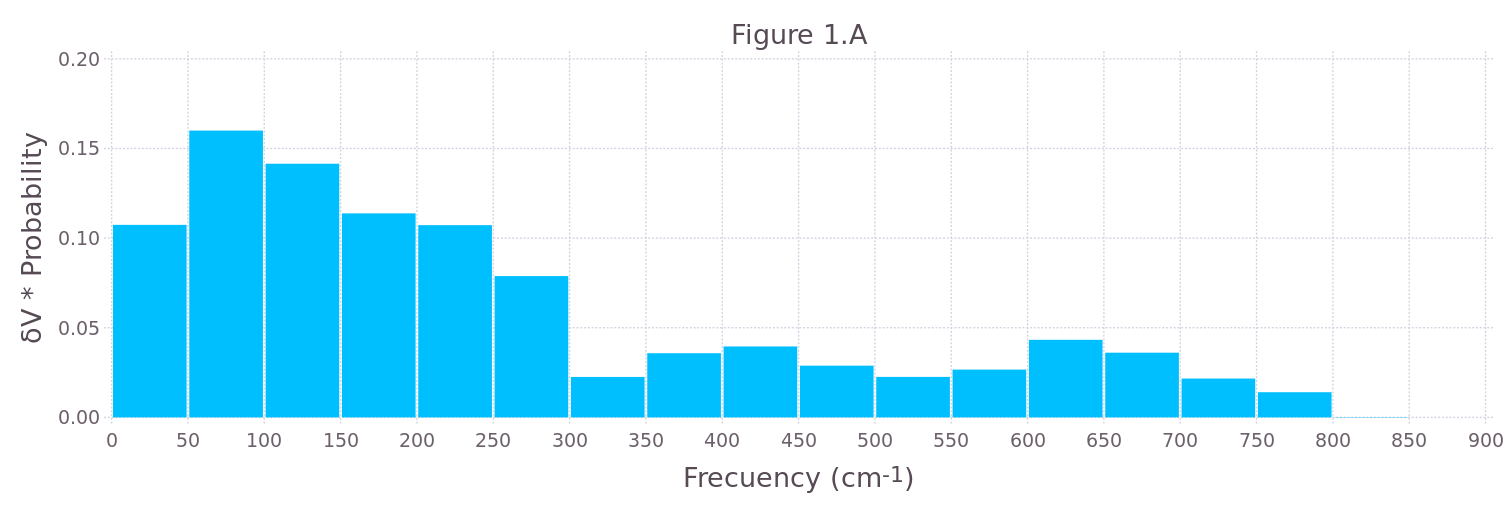

In [65]:
pdf_mode_freq_Whis = plot(df_mode_freq_Whis, x="Frequency", y="Probability", Geom.bar,
Guide.title("Figure 1.A"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:900)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Según colectividad

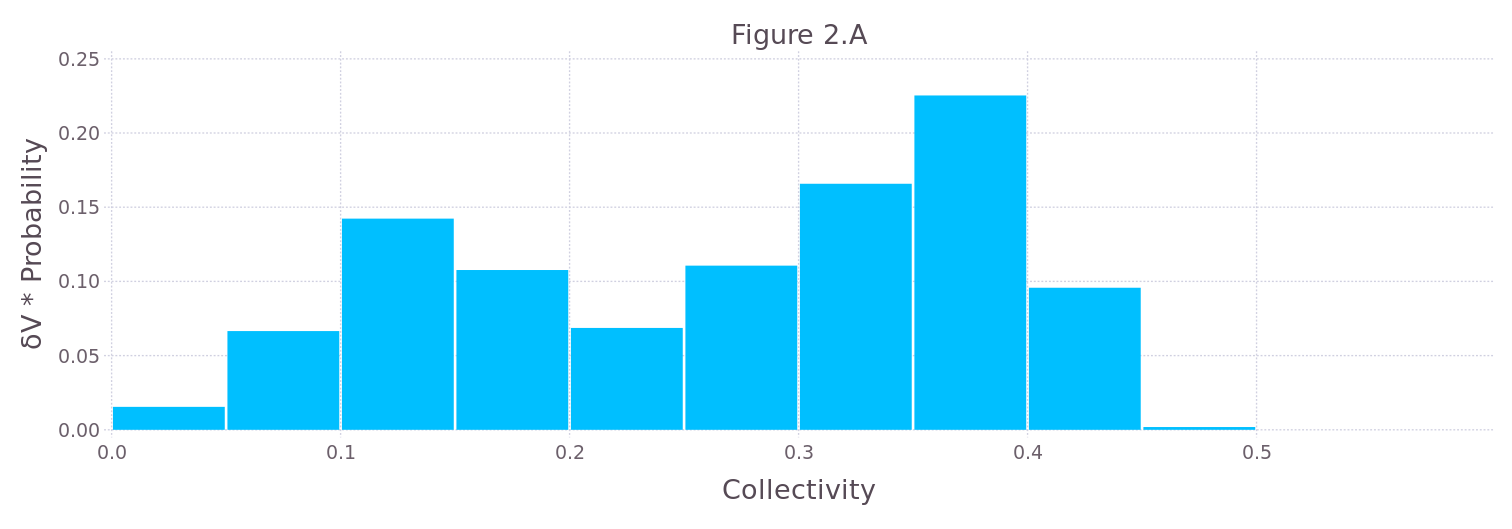

In [66]:
pdf_mode_κ_Whis = plot(df_mode_κ_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Figure 2.A"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.6),
Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

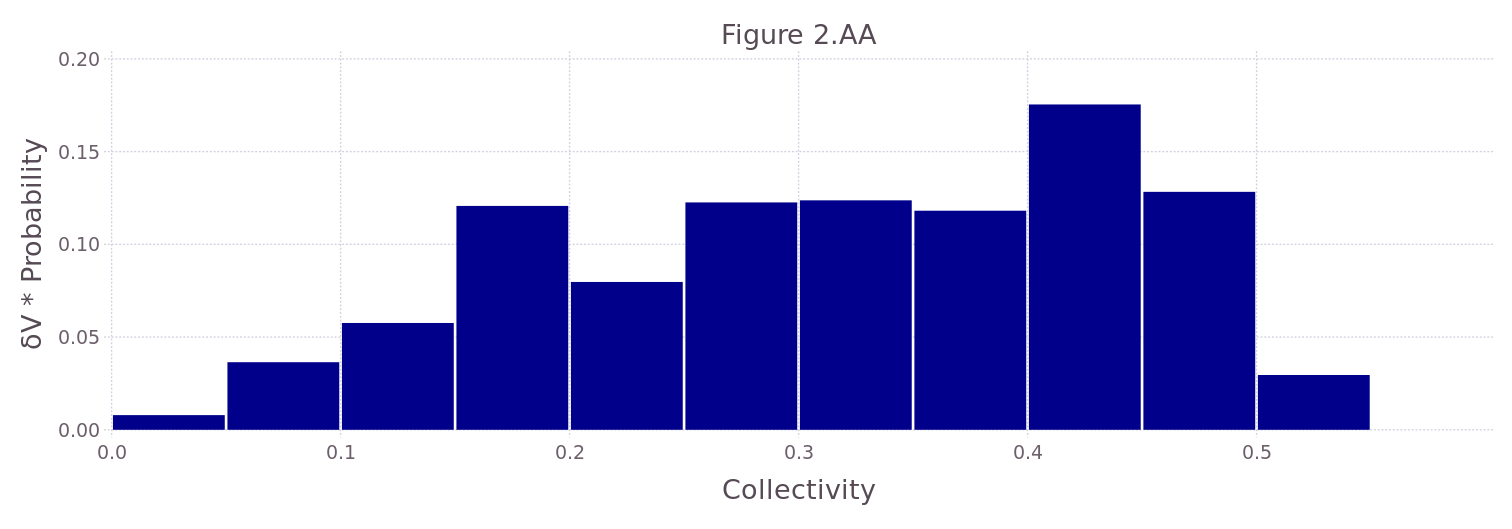

In [67]:
pdf_mode_κ_whole_Whis = plot(df_mode_κ_whole_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Figure 2.AA"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.6),
Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue "),
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Según Pnumber

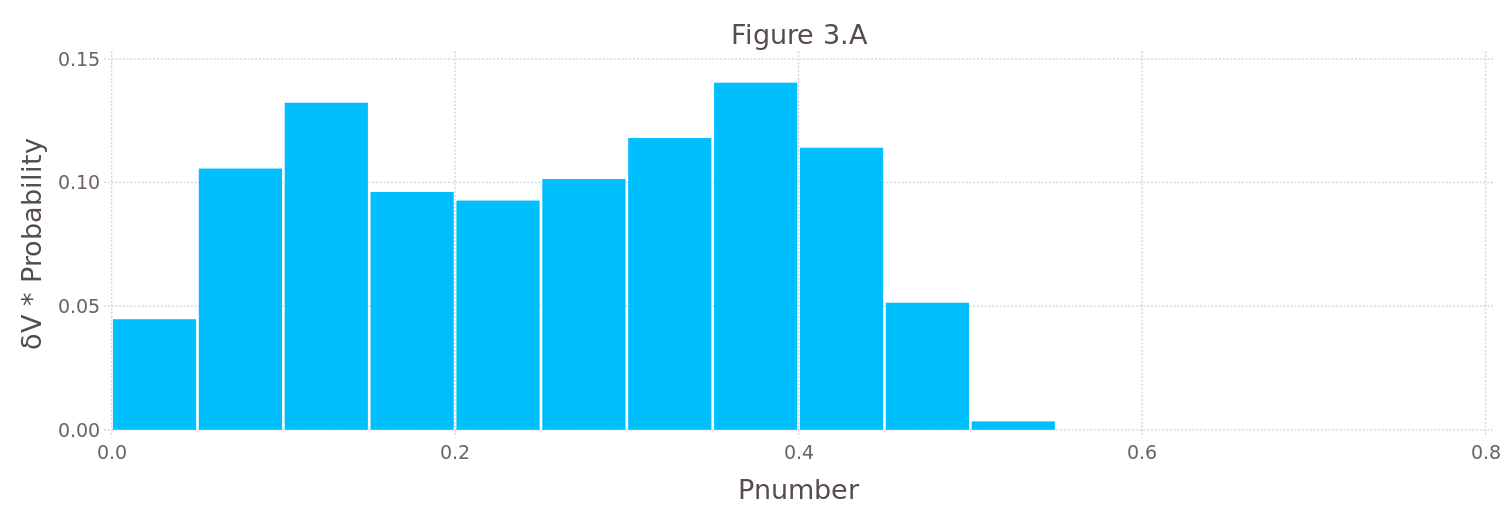

In [68]:
pdf_mode_pn_Whis = plot(df_mode_pn_Whis, x="Pnumber", y="Probability", Geom.bar,
Guide.title("Figure 3.A"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.8),
Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

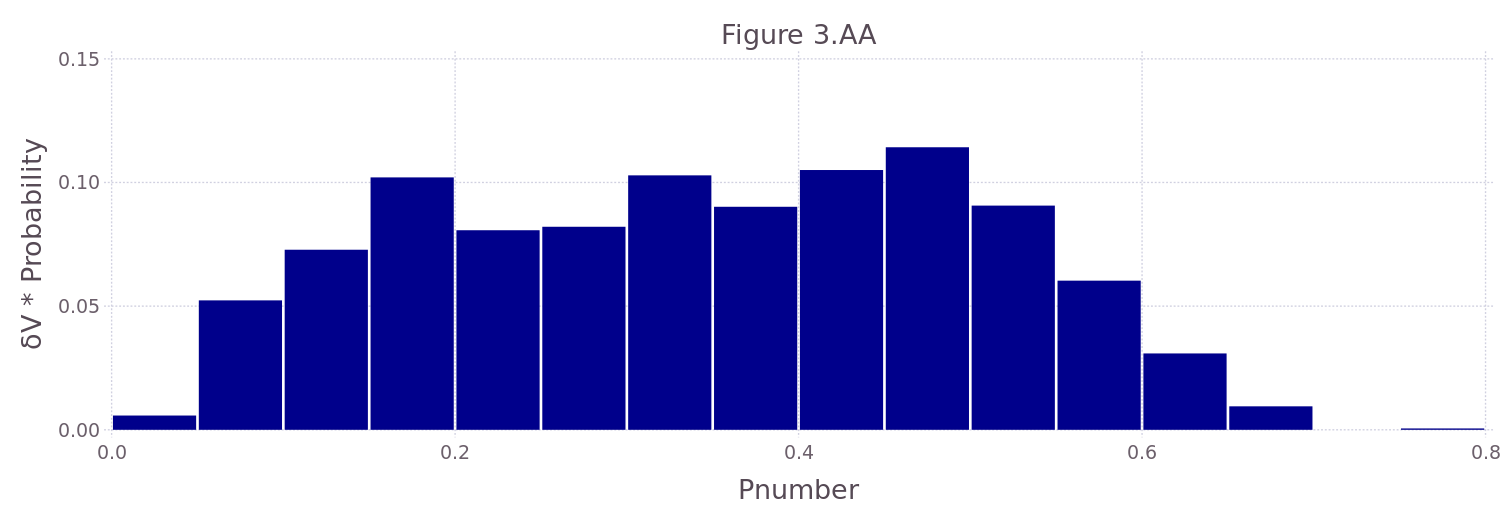

In [69]:
pdf_mode_pn_whole_Whis = plot(df_mode_pn_whole_Whis, x="Pnumber", y="Probability", Geom.bar,
Guide.title("Figure 3.AA"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.8),
Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue "),
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

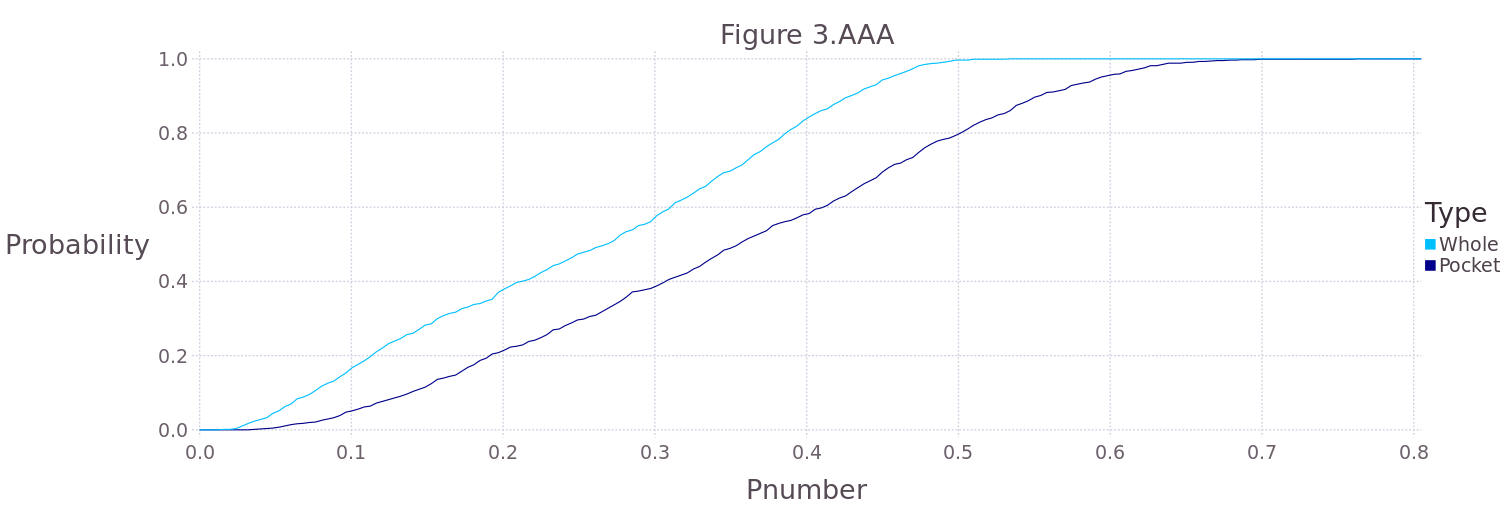

In [70]:
# Hago CDFs p/ comparar Pnumber de modos totales y recortados
layer_1 = layer([ecdf(pn_modes_prt)],0,1, Theme(default_color=colorant"deepskyblue"))
layer_2 = layer([ecdf(pn_modes_prt_whole)],0,1, Theme(default_color=colorant"DarkBlue "))

pdf_cdf_pnum_all = plot(layer_1, layer_2,
Guide.title("Figure 3.AAA"),
Guide.ylabel("Probability", orientation=:horizontal), Guide.xlabel("Pnumber"),
Guide.yticks(ticks=collect(0:0.2:1)), Guide.xticks(ticks=collect(0:0.1:0.8)),
Coord.cartesian(xmax=0.8),
Guide.manual_color_key("Type", ["Whole", "Pocket"], ["deepskyblue", "DarkBlue"]),
Theme(grid_line_width=1pt, key_label_font_size=14pt,
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# B: los 1eros "pnumber" modos

### Me quedo con los Pnumber modos, elementos de gradiente, frecuencias, colectividades y Pnumber de c/ modo

In [71]:
# Obtengo el pnumber
pnumber_gdte = convert(Int64, round(sum(gdte_whole .^ 4) .^ -1))
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes = sortperm(abs(gdte_whole), rev=true)[1:pnumber_gdte]
indices_pnum_modes = sort(indices_pnum_modes)

# Ahora recorto los modos, el gradiente, las frecuencias, las colectividades, los pnumber

# Me quedo con los "pnumber" modos. Uso los modos q ya fueron rellenados
modes_prt_pnum = modes_prt_1[:, indices_pnum_modes];
# Ahora los modos q fueron recortados. Normalizados y sin normalizar
modes_prt_1_whole_pnum_nonnorm = modes_prt_1_whole_nonnorm[:, indices_pnum_modes];
modes_prt_1_whole_pnum = modes_prt_1_whole[:, indices_pnum_modes];

# Me quedo con los ∇Volumen de los "pnumber" modos
gdte_whole_pnum = gdte_whole[indices_pnum_modes];
# Me quedo con las frequencias de los "pnumber" modos
evals_prt_pnum = evals_prt[indices_pnum_modes]
# Me quedo con las colectividades "pnumber" modos
κ_pnum = κ[indices_pnum_modes]
κ_whole_pnum = κ_whole[indices_pnum_modes]
# Me quedo con los pnumber (de aa's) de los "pnumber" modos
pn_modes_prt_pnum = pn_modes_prt[indices_pnum_modes];
pn_modes_prt_whole_pnum = pn_modes_prt_whole[indices_pnum_modes];

### Según frecuencia

In [72]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_freq_Whis

# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_prt_pnum) * 1.1
bins_freq = collect(0:50:top_freq)
unos_freq = repeat([1.0], inner=[length(evals_prt_pnum)])

# Histograma no ponderado
mode_freq_his, mode_freq_bins = WeightedHist(evals_prt_pnum, bins_freq, unos_freq, true);
df_mode_freq_pnum_his = DataFrame(Probability = mode_freq_his, Frequency = mode_freq_bins);

# Histograma ponderado
mode_freq_Whis, mode_freq_Wbins = WeightedHist(evals_prt_pnum, bins_freq, abs(gdte_whole_pnum), true);
df_mode_freq_pnum_Whis = DataFrame(Probability = mode_freq_Whis, Frequency = mode_freq_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_freq_Whis_state_dens = mode_freq_Whis ./ mode_freq_his
# Fix some NaNs caused by "divide by zero" error
mode_freq_Whis_state_dens[isnan(mode_freq_Whis_state_dens)] = 0
# Turn to density
mode_freq_Whis_state_dens = mode_freq_Whis_state_dens ./ sum(mode_freq_Whis_state_dens)
df_mode_freq_pnum_Whis_state_dens = DataFrame(Probability = mode_freq_Whis_state_dens, Frequency = mode_freq_Wbins);

### Según colectividad

In [73]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_κ_pnum_his

# Los bins van de 0 al valor del elemento más alto del gradiente + 10%
top_κ_pnum = maximum(κ_pnum) * 1.1
top_κ_whole_pnum = maximum(κ_whole_pnum) * 1.1 
bins_κ_pnum = collect(0:0.05:top_κ_pnum)
bins_κ_whole_pnum = collect(0:0.05:top_κ_whole_pnum)
unos_κ_pnum = repeat([1.0], inner=[length(κ_pnum)])

# Colectividad de modos enteros

# Histograma no ponderado
mode_κ_pnum_his, mode_κ_pnum_bins = WeightedHist(κ_pnum, bins_κ_pnum, unos_κ_pnum, true);
df_mode_κ_pnum_his = DataFrame(Probability = mode_κ_pnum_his, Collectivity = mode_κ_pnum_bins);

# Histograma por colectividad de modo
mode_κ_pnum_Whis, mode_κ_pnum_Wbins = WeightedHist(κ_pnum, bins_κ_pnum, abs(gdte_whole_pnum), true);
df_mode_κ_pnum_Whis = DataFrame(Probability = mode_κ_pnum_Whis, Collectivity = mode_κ_pnum_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_κ_pnum_Whis_state_dens = mode_κ_pnum_Whis ./ mode_κ_pnum_his
# Fix some NaNs caused by "divide by zero" error
mode_κ_pnum_Whis_state_dens[isnan(mode_κ_pnum_Whis_state_dens)] = 0
# Turn to density
mode_κ_pnum_Whis_state_dens = mode_κ_pnum_Whis_state_dens ./ sum(mode_κ_pnum_Whis_state_dens)
df_mode_κ_pnum_Whis_state_dens = DataFrame(Probability = mode_κ_pnum_Whis_state_dens,
    Collectivity = mode_κ_pnum_Wbins);


# Colectividad de modos recortados

# Histograma no ponderado
mode_κ_whole_pnum_his, mode_κ_whole_pnum_bins = WeightedHist(κ_whole_pnum, bins_κ_whole_pnum, unos_κ_pnum, true); 
df_mode_κ_whole_pnum_his = DataFrame(Probability = mode_κ_whole_pnum_his, Collectivity = mode_κ_whole_pnum_bins);

# Histograma por colectividad de modo
mode_κ_whole_pnum_Whis, mode_κ_whole_pnum_Wbins = WeightedHist(κ_whole_pnum, bins_κ_whole_pnum, abs(gdte_whole_pnum), true);
df_mode_κ_whole_pnum_Whis = DataFrame(Probability = mode_κ_whole_pnum_Whis, Collectivity = mode_κ_whole_pnum_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_κ_whole_pnum_Whis_state_dens = mode_κ_whole_pnum_Whis ./ mode_κ_whole_pnum_his
# Fix some NaNs caused by "divide by zero" error
mode_κ_whole_pnum_Whis_state_dens[isnan(mode_κ_whole_pnum_Whis_state_dens)] = 0
# Turn to density
mode_κ_whole_pnum_Whis_state_dens = mode_κ_whole_pnum_Whis_state_dens ./ sum(mode_κ_whole_pnum_Whis_state_dens)
df_mode_κ_whole_pnum_Whis_state_dens = DataFrame(Probability = mode_κ_whole_pnum_Whis_state_dens,
    Collectivity = mode_κ_whole_pnum_Wbins);

### Según Pnumber

In [74]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_pn_pnum_his

# Los bins van de 0 al pnumber más alto + 10%
top_pn_a = maximum(pn_modes_prt_pnum) * 1.1
top_pn_whole_a = maximum(pn_modes_prt_whole_pnum) * 1.1
bins_pn_a = collect(0:0.05:top_pn_a)
bins_pn_whole_a = collect(0:0.05:top_pn_whole_a)
unos_pn = repeat([1.0], inner=[length(pn_modes_prt_pnum)])

# Pnumber de modos enteros

# Histograma no ponderado
mode_pn_his, mode_pn_bins = WeightedHist(pn_modes_prt_pnum, bins_pn_a, unos_pn, true);
df_mode_pn_pnum_his = DataFrame(Probability = mode_pn_his, Pnumber = mode_pn_bins);

# Histograma por colectividad de modo
mode_pn_Whis, mode_pn_Wbins = WeightedHist(pn_modes_prt_pnum, bins_pn_a, abs(gdte_whole_pnum), true);
df_mode_pn_pnum_Whis = DataFrame(Probability = mode_pn_Whis, Pnumber = mode_pn_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_pn_Whis_state_dens = mode_pn_Whis ./ mode_pn_his
# Fix some NaNs caused by "divide by zero" error
mode_pn_Whis_state_dens[isnan(mode_pn_Whis_state_dens)] = 0
# Turn to density
mode_pn_Whis_state_dens = mode_pn_Whis_state_dens ./ sum(mode_pn_Whis_state_dens)
df_mode_pn_pnum_Whis_state_dens = DataFrame(Probability = mode_pn_Whis_state_dens,
    Pnumber = mode_pn_Wbins);


# Pnumber de modos recortados

# Histograma no ponderado
mode_pn_whole_his, mode_pn_whole_bins = WeightedHist(pn_modes_prt_whole_pnum, bins_pn_whole_a, unos_pn, true);
df_mode_pn_whole_pnum_his = DataFrame(Probability = mode_pn_whole_his, Pnumber = mode_pn_whole_bins);

# Histograma por colectividad de modo
mode_pn_whole_Whis, mode_pn_whole_Wbins = WeightedHist(pn_modes_prt_whole_pnum, bins_pn_whole_a, abs(gdte_whole_pnum), true);
df_mode_pn_whole_pnum_Whis = DataFrame(Probability = mode_pn_whole_Whis, Pnumber = mode_pn_whole_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_pn_whole_Whis_state_dens = mode_pn_whole_Whis ./ mode_pn_whole_his
# Fix some NaNs caused by "divide by zero" error
mode_pn_whole_Whis_state_dens[isnan(mode_pn_whole_Whis_state_dens)] = 0
# Turn to density
mode_pn_whole_pnum_Whis_state_dens = mode_pn_whole_Whis_state_dens ./ sum(mode_pn_whole_Whis_state_dens)
df_mode_pnwhole_Whis_state_dens = DataFrame(Probability = mode_pn_whole_Whis_state_dens,
    Pnumber = mode_pn_whole_Wbins);

## Gráficos de B: los 1eros "pnumber" modos

### Según frecuencia

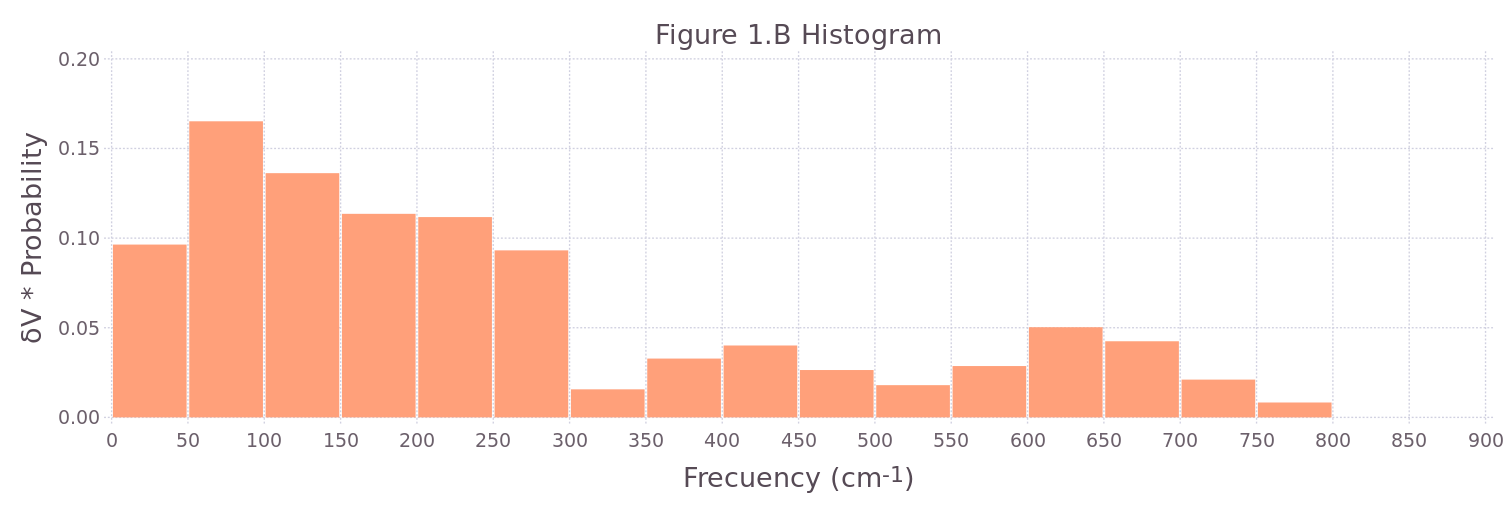

In [75]:
pdf_mode_freq_pnum_Whis = plot(df_mode_freq_pnum_Whis, x="Frequency", y="Probability", Geom.bar,
Guide.title("Figure 1.B Histogram"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:900)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Según colectividad

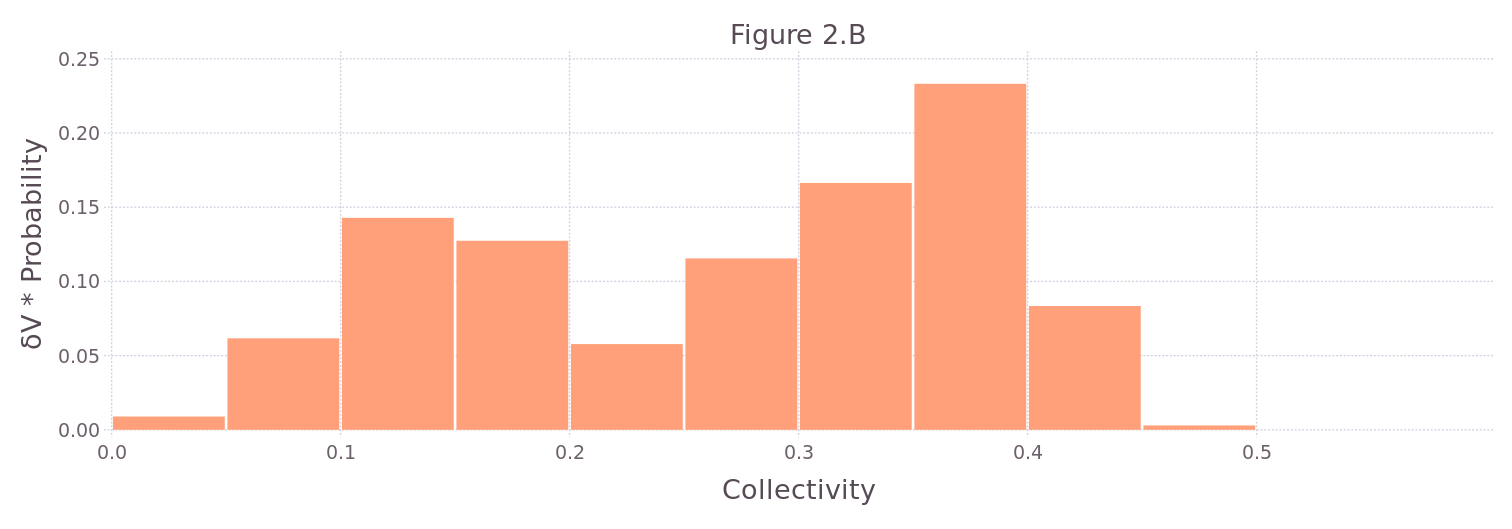

In [76]:
pdf_mode_κ_pnum_Whis = plot(df_mode_κ_pnum_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Figure 2.B"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.6),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"LightSalmon", 
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

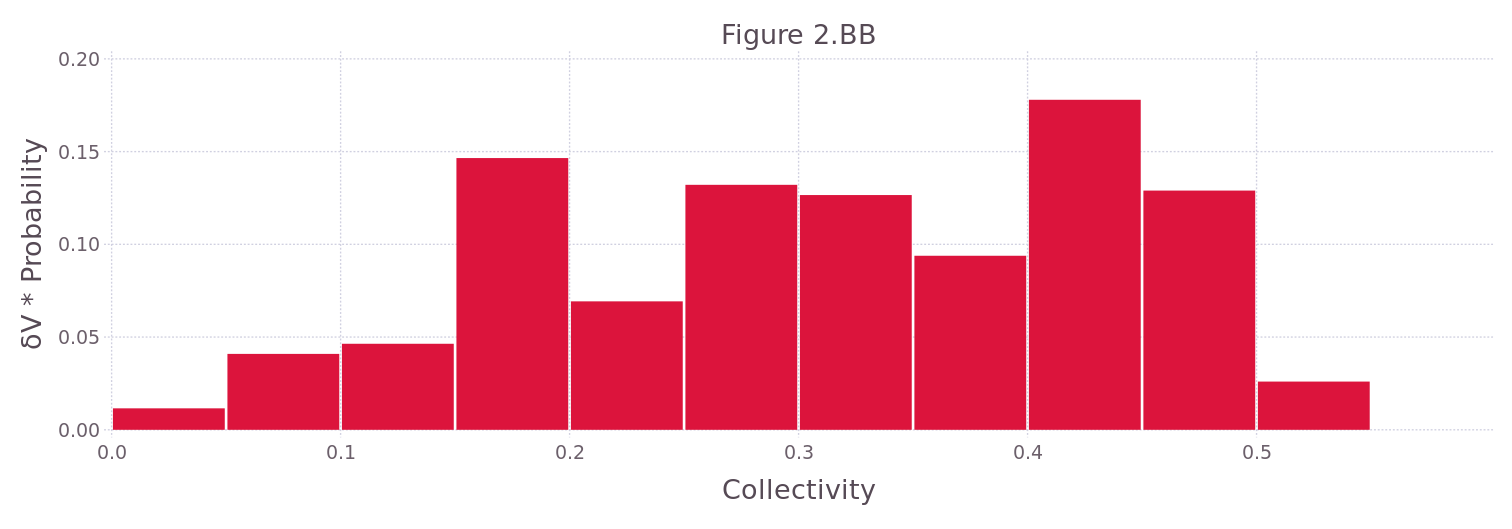

In [77]:
pdf_mode_κ_whole_pnum_Whis = plot(df_mode_κ_whole_pnum_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Figure 2.BB"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.6),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"crimson",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Según Pnumber

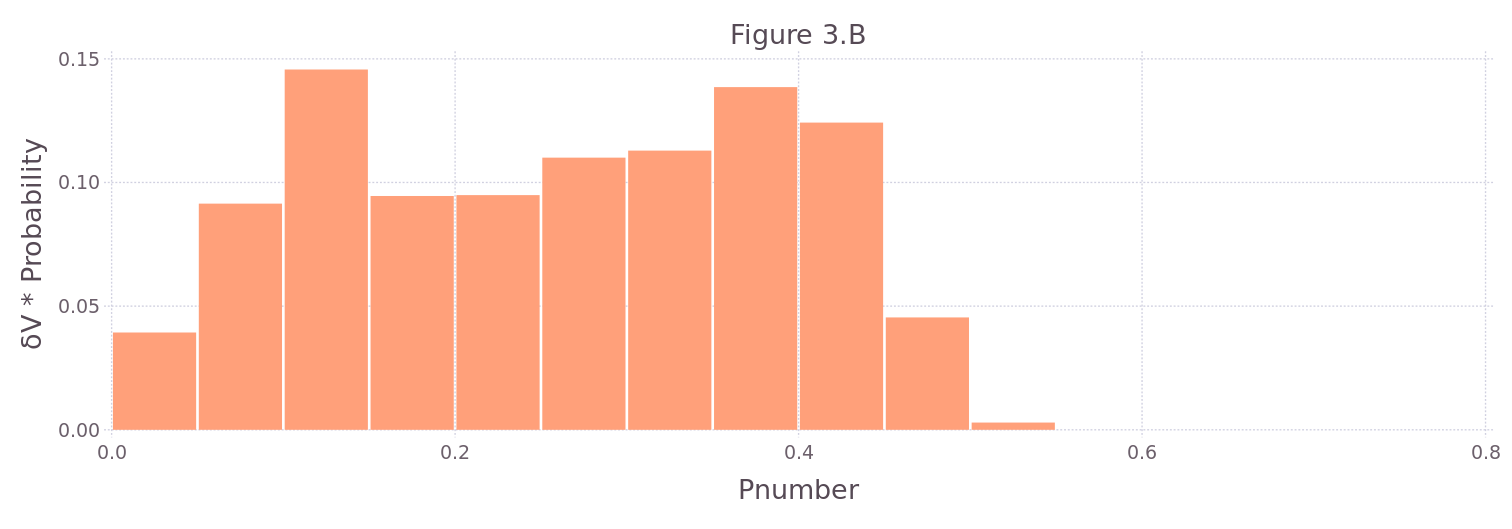

In [78]:
pdf_mode_pn_pnum_Whis = plot(df_mode_pn_pnum_Whis, x="Pnumber", y="Probability", Geom.bar,
Guide.title("Figure 3.B"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.8),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"LightSalmon",  
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

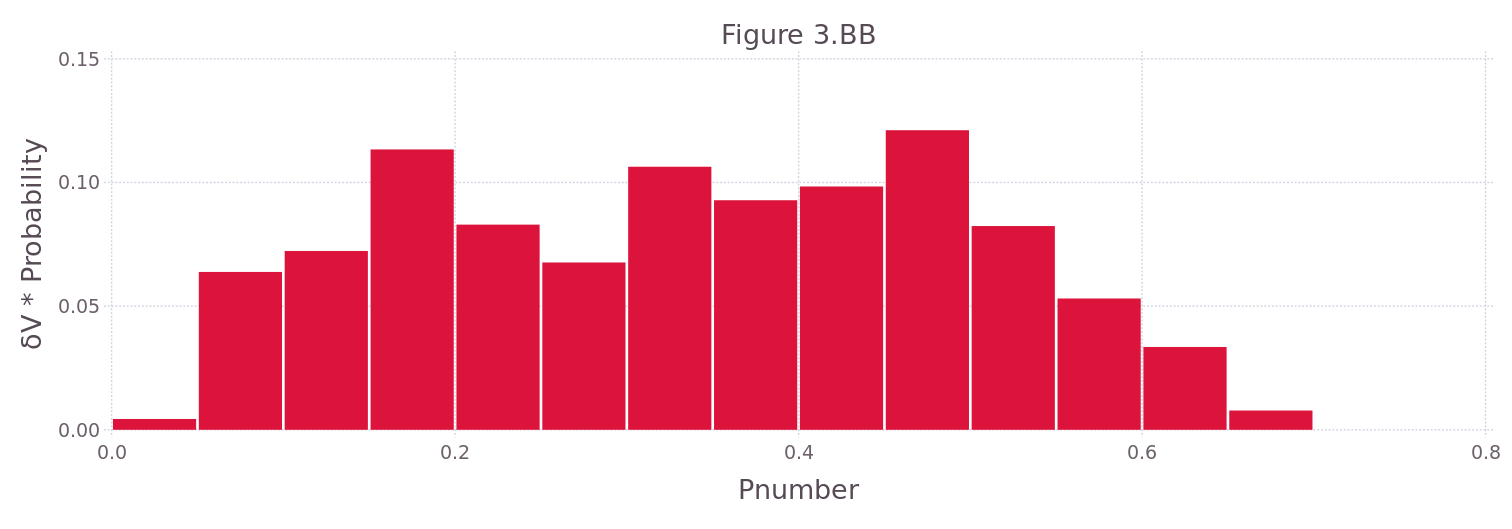

In [79]:
pdf_mode_pn_whole_pnum_Whis = plot(df_mode_pn_whole_pnum_Whis, x="Pnumber", y="Probability", Geom.bar,
Guide.title("Figure 3.BB"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.8), 
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"crimson", 
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

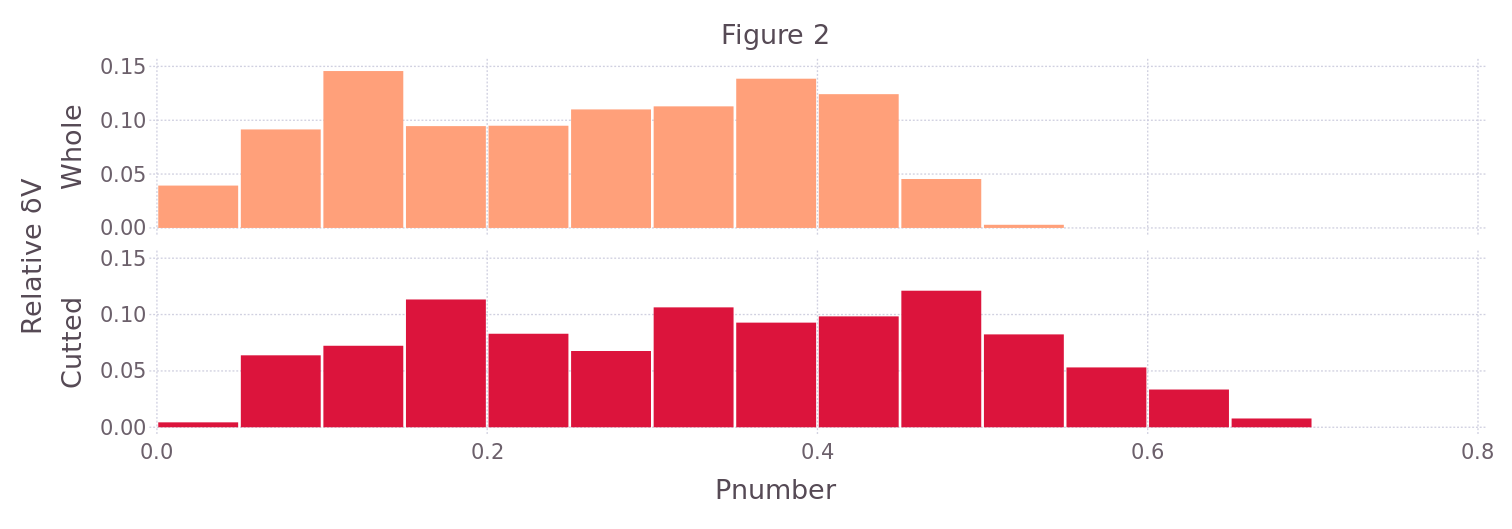

In [80]:
df_mode_pn_pnum_Whis_both = DataFrame(
    Probability = [ mode_pn_Whis ; mode_pn_whole_Whis ], 
Pnumber = [ mode_pn_Wbins ; mode_pn_whole_Wbins ], 
Type = [ repeat(["Whole"], inner = [length(df_mode_pn_pnum_Whis[:, 1])]) ;
    repeat(["Cutted"], inner = [length(df_mode_pn_whole_pnum_Whis[:, 1])]) ]);

pdf_mode_pn_pnum_Whis_both = plot(df_mode_pn_pnum_Whis_both,
x="Pnumber", y="Probability", ygroup = "Type", color = "Type",
Geom.subplot_grid(Geom.bar),
Scale.color_discrete_manual(colorant"LightSalmon",colorant"crimson"),
Guide.title("Figure 2"),
Guide.ylabel("Relative δV", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt, key_position=:none,
minor_label_font_size = 16pt, major_label_font_size = 20pt))

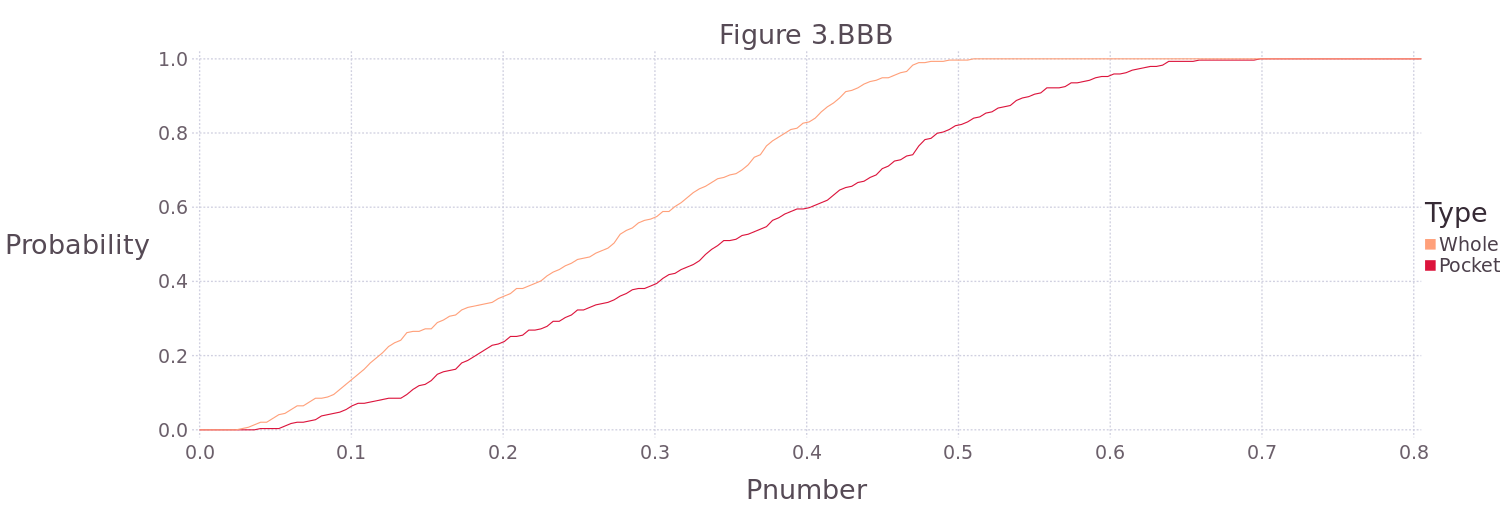

In [81]:
# Hago CDFs p/ comparar Pnumber de modos totales y recortados
layer_1 = layer([ecdf(pn_modes_prt_pnum)],0,1, Theme(default_color=colorant"LightSalmon"))
layer_2 = layer([ecdf(pn_modes_prt_whole_pnum)],0,1, Theme(default_color=colorant"crimson "))

pdf_cdf_pnum_pn_all = plot(layer_1, layer_2,
Guide.title("Figure 3.BBB"),
Guide.ylabel("Probability", orientation=:horizontal), Guide.xlabel("Pnumber"),
Guide.yticks(ticks=collect(0:0.2:1)), Guide.xticks(ticks=collect(0:0.1:0.8)),
Coord.cartesian(xmax=0.8),
Guide.manual_color_key("Type", ["Whole", "Pocket"], ["LightSalmon", "crimson"]),
Theme(grid_line_width=1pt, key_label_font_size=14pt,
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Hay modos con frecuencia de 175  1/cm a 200 1/cm q mueven considerablemente al hueco

In [82]:
# Hago la mask p/ ir filtrando según las frecuencias de interés
mask_175_200 = 175 .< evals_prt .< 200
evals_prt_pico = evals_prt[mask_175_200]

# Me quedo con los modos en cuestión
modes_prt_pico = modes_prt[:, mask_175_200]
# Los pnumber de los susodichos modos
pnum_modes_prt_pico = pnum_modes_prt[mask_175_200]
# Redondeo
pnum_modes_prt_pico = convert(Array{Int64, 1}, round(pnum_modes_prt_pico))

# Los pnumber de los susodichos modos
pn_modes_prt_pico = pn_modes_prt[mask_175_200];

# Lista ordenada de aminoácidos más movidos por c/ modo
full_aa_pnum_each_mode = mapslices(x -> sortperm(x), mapslices(x -> tognm(x), modes_prt_pico, 1), 1);

In [83]:
aa_pnum_each_mode = Array{Int64, 1}
nres_whole_pnum_each_mode = Array{Int64, 1}(0)
i = 1
for pnum in pnum_modes_prt_pico
    # Tomo los 1eros "pnumber" aminoácidos más movidos por c/ modo
    aa_pnum_each_mode = full_aa_pnum_each_mode[1:pnum, i]
    # Me fijo cuantos de esos aminoácidos son de pared
    push!(nres_whole_pnum_each_mode, length(findin(indices_gdte_whole, aa_pnum_each_mode)))
    i = i + 1
end
# Divido (el conteo de aa's de pared en los "pnumber" aminoácidos movidos por c/ modo) por (el nro total de
# aa's de paredes)
pttion_whole_pnum_each_mode = nres_whole_pnum_each_mode ./ length(indices_gdte_whole);
# Divido (el conteo de aa's de pared en los "pnumber" aminoácidos movidos por c/ modo) por (el nro total de
# aa's movidos por ese modo)
specificity_whole_pnum_each_mode = nres_whole_pnum_each_mode ./ pnum_modes_prt_pico

# Ahora hago un dataframe p/ plotear
proper_labels = repeat(map(x->string(x), round(evals_prt_pico, 2)), outer=[2])
proper_labels = reshape(transpose([ map(x->string(x), round(evals_prt_pico, 2))  repeat([" "], inner=[length(evals_prt_pico)]) ]), 62)
df_pttion_whole_pnum_each_mode = DataFrame(
    Proportion = [ pttion_whole_pnum_each_mode; specificity_whole_pnum_each_mode ],
    Frequency = repeat(round(evals_prt_pico, 1), outer=[2]),
    Labels = proper_labels,
    X = repeat(collect(1:1:length(pnum_modes_prt_pico)), outer=[2]),
    Name = repeat(["Partition", "Specificity"], inner=[length(pnum_modes_prt_pico)]));

LoadError: LoadError: DimensionMismatch("new dimensions (62,) must be consistent with array size 88")
while loading In[83], in expression starting on line 20

In [84]:
pdf_pttion_whole_pnum_each_mode = plot(df_pttion_whole_pnum_each_mode,
    Geom.bar(position=:dodge), y="Proportion", color = "Name",
    x = "Frequency",
    #Geom.label(), label="Labels",
    Guide.xlabel("Modes between 175cm-1 and 200cm-1"),
    Guide.title("(Wall residues / total \"Pnumber\" residues residues) in selected modes "),
    #Guide.xticks(orientation=:horizontal),
    Scale.x_discrete,
    Coord.cartesian(ymax = 0.4),
    Theme(bar_spacing=10pt, grid_line_width=0pt, 
    minor_label_font_size = 12pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
    key_label_font_size = 15pt))

LoadError: LoadError: UndefVarError: df_pttion_whole_pnum_each_mode not defined
while loading In[84], in expression starting on line 1

In [85]:
pdf_pttion_whole_pnum_each_mode = plot(df_pttion_whole_pnum_each_mode,
    Geom.bar(), y="Proportion", color = "Name",
    x = "Frequency",
    #Geom.label(), label="Labels",
    Guide.xlabel("Modes between 175cm-1 and 200cm-1"),
    Guide.title("(Wall residues / total \"Pnumber\" residues residues) in selected modes "),
    #Guide.xticks(orientation=:horizontal),
    Scale.x_discrete,
    Coord.cartesian(ymax = 0.8),
    Theme(bar_spacing=10pt, 
    minor_label_font_size = 12pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
    key_label_font_size = 15pt))

LoadError: LoadError: UndefVarError: df_pttion_whole_pnum_each_mode not defined
while loading In[85], in expression starting on line 1

In [86]:
partition_each_25 = Array{Float64, 1}(0)
specificity_each_25 = Array{Float64, 1}(0)
excess = 0

# Hago la mask p/ ir filtrando según las frecuencias de interés
for left in bins_freq_a
    mask = left .< evals_prt .< left+25
    if sum(mask) == 0
        # In case no haya frecuencia q cumpla con el requisito
        excess = excess + 1
        continue 
    end
    evals_prt_pico = evals_prt[mask]

    # Me quedo con los modos en cuestión
    modes_prt_pico = modes_prt[:, mask]
    # Los pnumber redondeados de los susodichos modos
    pnum_modes_prt_pico = convert(Array{Int64, 1}, round(pnum_modes_prt[mask]))
    
    # Lista ordenada de aminoácidos más movidos por c/ modo
    full_aa_pnum_each_mode = mapslices(x -> sortperm(x), mapslices(x -> tognm(x), modes_prt_pico, 1), 1)   
    
    aa_pnum_each_mode = Array{Int64, 1}
    nres_whole_pnum_each_mode = Array{Int64, 1}(0)
    i = 1
    for pnum in pnum_modes_prt_pico
        # Tomo los 1eros "pnumber" aminoácidos más movidos por c/ modo
        aa_pnum_each_mode = full_aa_pnum_each_mode[1:pnum, i]
        # Me fijo cuantos de esos aminoácidos son de pared y los guardo 
        push!(nres_whole_pnum_each_mode, length(findin(indices_gdte_whole, aa_pnum_each_mode)))
        i = i + 1
    end
    # Divido (el conteo de aa's de pared en los "pnumber" aminoácidos movidos por c/ modo) por (el nro total de
    # aa's de paredes)
    pttion_whole_pnum_each_mode = nres_whole_pnum_each_mode ./ length(indices_gdte_whole);
    # Divido (el conteo de aa's de pared en los "pnumber" aminoácidos movidos por c/ modo) por (el nro total de
    # aa's movidos por ese modo)
    specificity_whole_pnum_each_mode = nres_whole_pnum_each_mode ./ pnum_modes_prt_pico
    
    # Finalmente, guardo las 2 variables q me interesan
    push!(partition_each_25, sum(pttion_whole_pnum_each_mode))
    push!(specificity_each_25, sum(specificity_whole_pnum_each_mode))
end

# Armo los dataframes para plottear
df_partition_each_25 = DataFrame(Proportion = partition_each_25,
    Frequency = mode_freq_bins)
df_specificity_each_25 = DataFrame(Proportion = specificity_each_25,
    Frequency = mode_freq_bins);

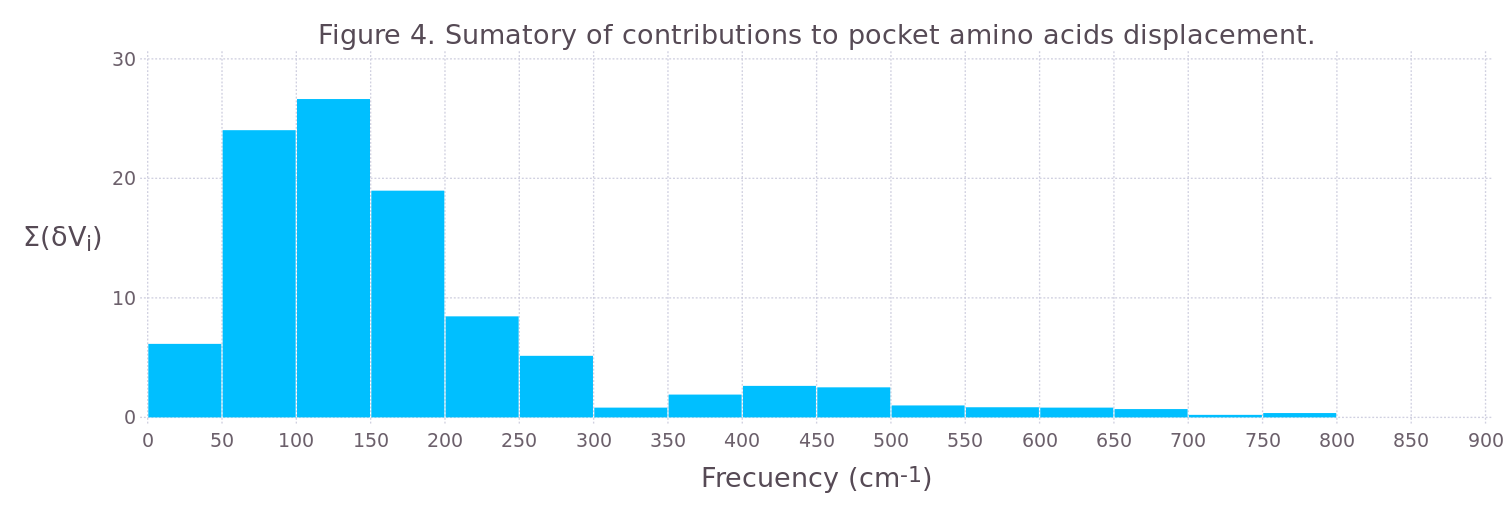

In [87]:
pdf_partition_pn_whole_pnum_Whis = plot(df_partition_each_25, x="Frequency", y="Proportion", Geom.bar,
Guide.title("Figure 4. Sumatory of contributions to pocket amino acids displacement."),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:900)),
Guide.ylabel("Σ(δV<sub>i</sub>)", orientation=:horizontal),
Theme(bar_spacing = 1pt, grid_line_width=1pt, 
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

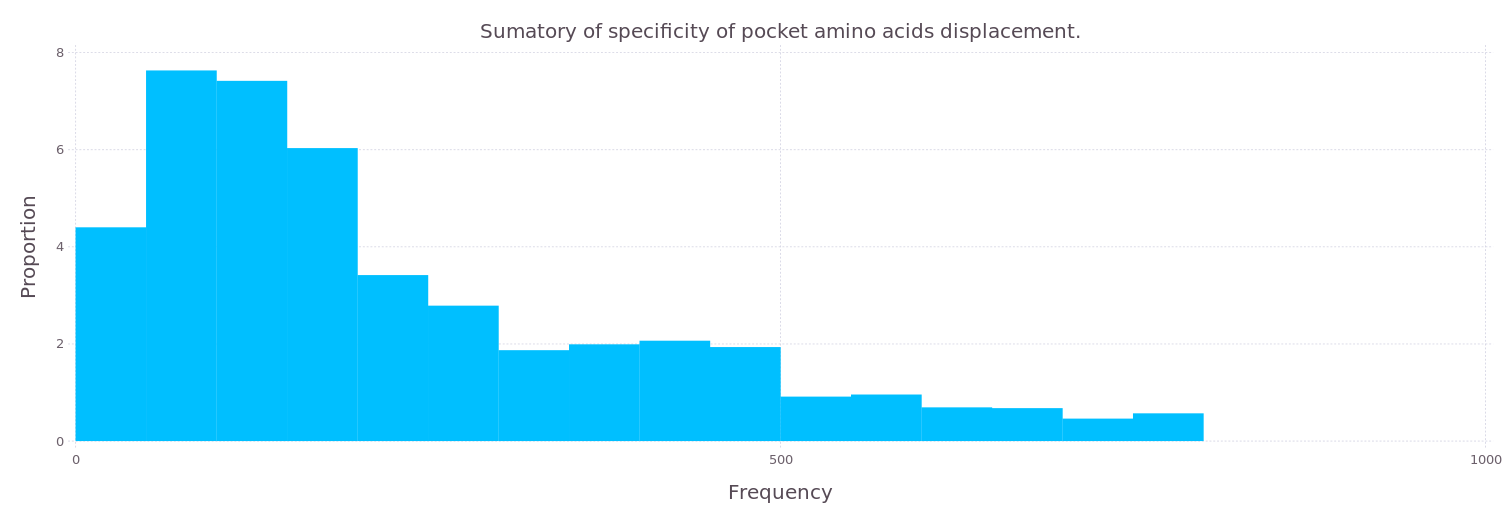

In [88]:
pdf_specificity_pn_whole_pnum_Whis = plot(df_specificity_each_25, x="Frequency", y="Proportion", Geom.bar,
Guide.title("Sumatory of specificity of pocket amino acids displacement."),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

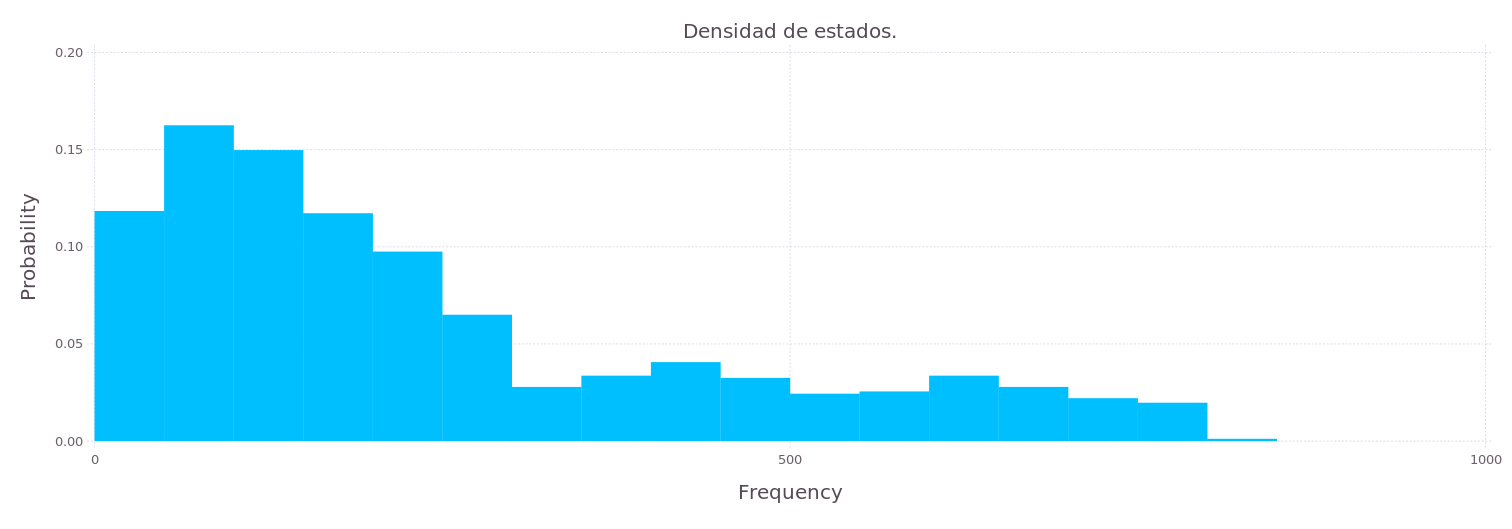

In [89]:
plot(df_mode_freq_his, x="Frequency", y="Probability", Geom.bar,
Guide.title("Densidad de estados."),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Hago un gráfico similar al "Figure 4", pero con las contribuciones crudas a c/ aa

In [90]:
# Todos los modos

# Obtengo sumatoria de Ci de c/ aminoácido del hueco p/ c/ modo
ci_whole = mapslices(x -> sum(x), modes_prt_1_whole_nonnorm .^ 2, 1)

# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_prt) * 1.1
bins_freq = collect(0:50:top_freq)

# Histograma no ponderado
ci_freq_his, ci_freq_bins = WeightedHist(evals_prt, bins_freq, ci_whole, true);
df_ci_freq_his = DataFrame(Probability = ci_freq_his, Frequency = ci_freq_bins);

############

# Los Pnumber modos
# Obtengo sumatoria de Ci de c/ aminoácido del hueco p/ c/ modo (de los 1eros pnumber)
ci_whole_pnum = mapslices(x -> sum(x), modes_prt_1_whole_pnum_nonnorm .^ 2, 1)

# Los bins van de 0 a la fqcia más alta + 10%
top_freq_pnum = maximum(evals_prt_pnum) * 1.1
bins_freq_pnum = collect(0:50:top_freq_pnum)

# Histograma no ponderado
ci_pnum_freq_his, ci_pnum_freq_bins = WeightedHist(evals_prt_pnum, bins_freq, ci_whole_pnum, true);
df_ci_pnum_freq_his = DataFrame(Probability = ci_pnum_freq_his, Frequency = ci_pnum_freq_bins);

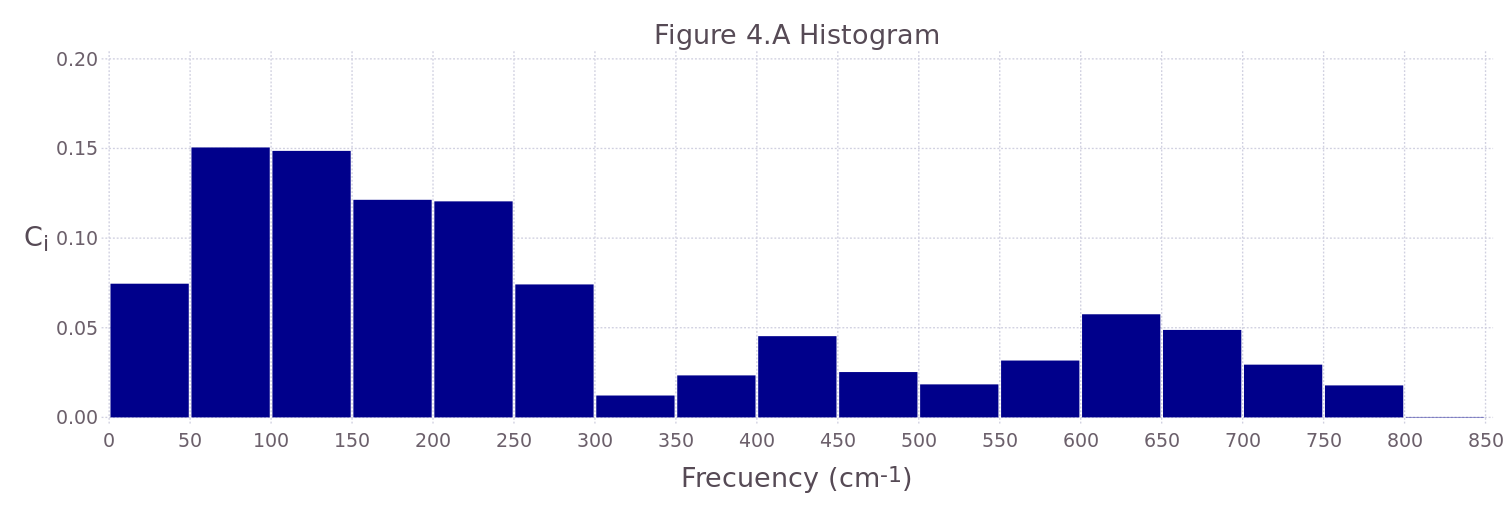

In [91]:
pdf_ci_freq_his = plot(df_ci_freq_his, x="Frequency", y="Probability", Geom.bar,
Guide.title("Figure 4.A Histogram"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:top_freq)),
Guide.ylabel("C<sub>i</sub>", orientation=:horizontal),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"DarkBlue", 
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

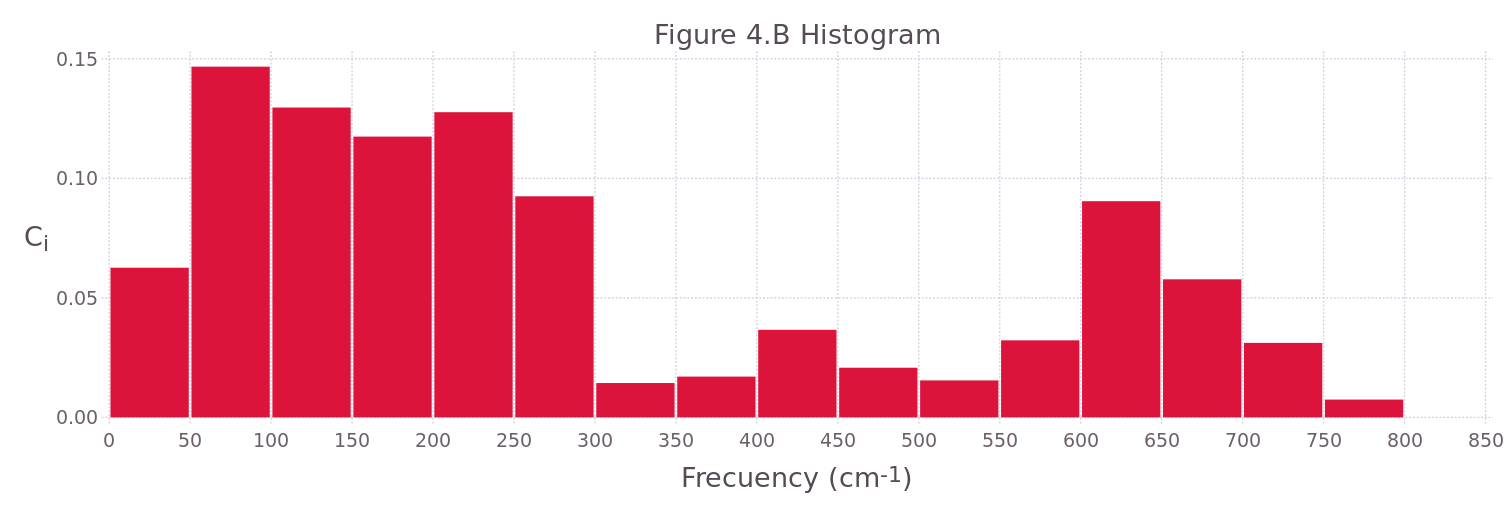

In [92]:
pdf_ci_pnum_freq_his = plot(df_ci_pnum_freq_his, x="Frequency", y="Probability", Geom.bar,
Guide.title("Figure 4.B Histogram"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:top_freq)),
Guide.ylabel("C<sub>i</sub>", orientation=:horizontal),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"crimson", 
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Anexo

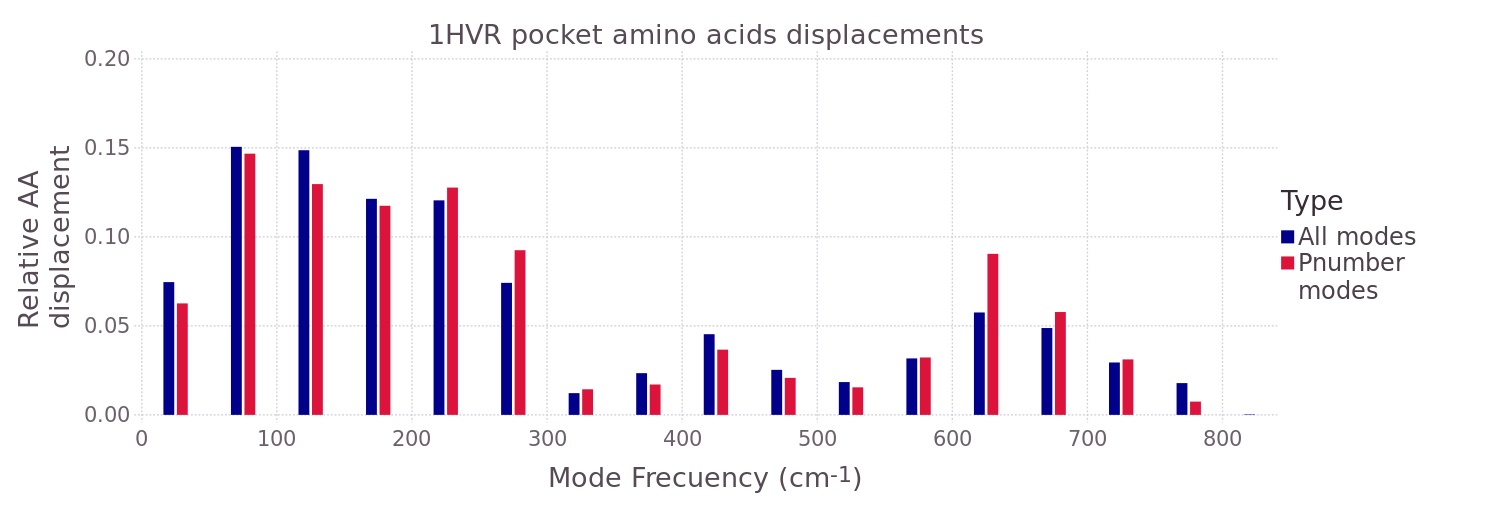

In [93]:
# Junto ambos datasets:
df_ci_all_freq_his = DataFrame(Probability = [ ci_freq_his ; ci_pnum_freq_his ],
Frequency = [ ci_freq_bins .- 5 ; ci_freq_bins .+ 5 ],
Type = repeat(["All modes" ; "\nPnumber\nmodes"], inner = [length(ci_freq_bins)]));

layer_temp = layer(df_ci_all_freq_his, x="Frequency", y="Probability", color = "Type",
Geom.bar(), 
Theme(minor_label_font_size = 28pt, major_label_font_size = 18pt, key_title_font_size=18pt, key_label_font_size=15pt))

pdf_ci_all_freq_his = plot(df_ci_all_freq_his,
Guide.title("1HVR pocket amino acids displacements"),
Guide.xlabel("Mode Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:100:top_freq)),
Guide.ylabel("Relative AA\ndisplacement"), Scale.color_discrete_manual(colorant"DarkBlue",colorant"crimson"),
x="Frequency", y="Probability", color = "Type",
Geom.bar(), 
Theme(bar_spacing=2pt, grid_line_width=1pt, key_label_font_size=18pt,
minor_label_font_size = 16pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

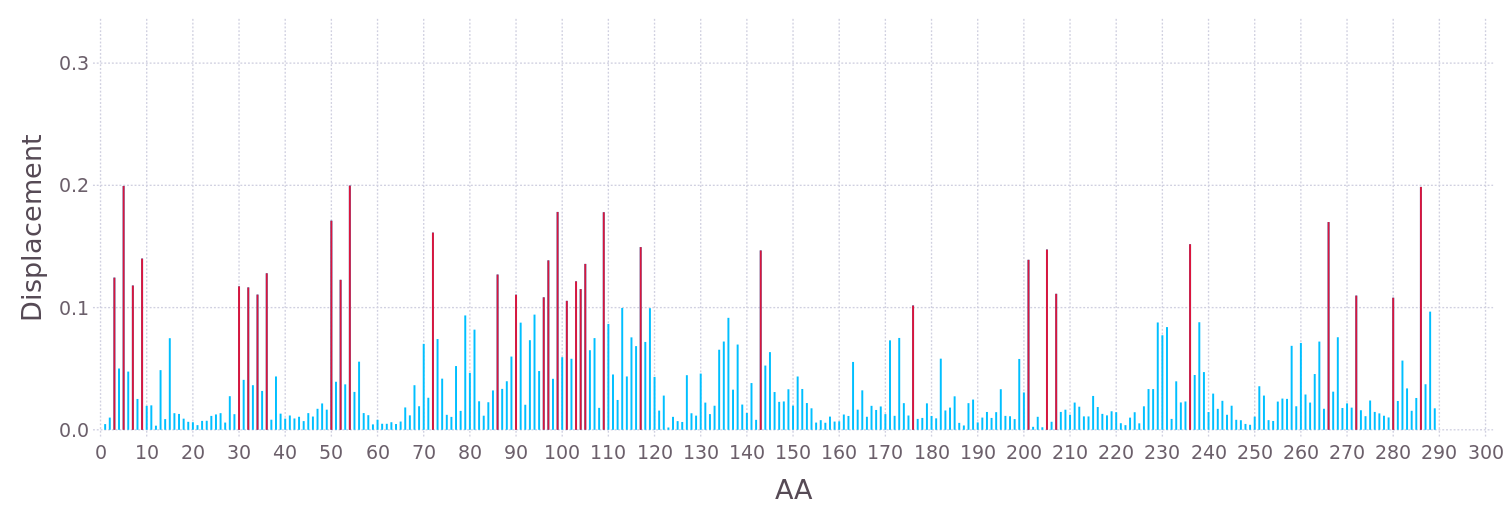

In [94]:
cart_gdte_whole = tognm(modes_prt * gdte_whole)
high_cart_gdte_whole = copy(cart_gdte_whole)
for i=1:length(high_cart_gdte_whole)
    if cart_gdte_whole[i] < 0.1
        high_cart_gdte_whole[i] = 0
    end
end

layer_temp_1 = layer(DataFrame(Displacement = cart_gdte_whole), Geom.bar, y = "Displacement")
layer_temp_2 = layer(DataFrame(Displacement = high_cart_gdte_whole), Geom.bar, y = "Displacement",
Theme(default_color=colorant"crimson", bar_spacing=2pt))



pdf_cart_gdte = plot(layer_temp_2, layer_temp_1,
Guide.xlabel("AA"), Guide.xticks(ticks=collect(0:10:300)),
Guide.ylabel("Displacement"), Coord.cartesian(ymax = 0.33),
Theme(bar_spacing=2pt, grid_line_width=1pt,
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
key_label_font_size = 15pt))

### Guardo gráficos en .pdf

#### Frecuencia

In [95]:
out_filename_1a = string("/home/german/labo/16/exs/rtdos_log/1prn/1afigure.pdf")
out_filename_1b = string("/home/german/labo/16/exs/rtdos_log/1prn/1bfigure.pdf")
# Guardo los plots
draw(PDF(out_filename_1a, 30cm, 14cm), pdf_mode_freq_Whis)
draw(PDF(out_filename_1b, 30cm, 14cm), pdf_mode_freq_pnum_Whis)

#### Colectividad

In [96]:
out_filename_2a = string("/home/german/labo/16/exs/rtdos_log/1prn/2afigure.pdf")
out_filename_2aa = string("/home/german/labo/16/exs/rtdos_log/1prn/2aafigure.pdf")
out_filename_2b = string("/home/german/labo/16/exs/rtdos_log/1prn/2bfigure.pdf")
out_filename_2bb = string("/home/german/labo/16/exs/rtdos_log/1prn/2bbfigure.pdf")
# Guardo los plots
draw(PDF(out_filename_2a, 30cm, 14cm), pdf_mode_κ_Whis)
draw(PDF(out_filename_2aa, 30cm, 14cm), pdf_mode_κ_whole_Whis )
draw(PDF(out_filename_2b, 30cm, 14cm), pdf_mode_κ_pnum_Whis)
draw(PDF(out_filename_2bb, 30cm, 14cm), pdf_mode_κ_whole_pnum_Whis)

#### Pnumber

In [97]:
out_filename_3a = string("/home/german/labo/16/exs/rtdos_log/1prn/3afigure.pdf")
out_filename_3aa = string("/home/german/labo/16/exs/rtdos_log/1prn/3aafigure.pdf")
out_filename_3aaa = string("/home/german/labo/16/exs/rtdos_log/1prn/3aaafigure.pdf")
out_filename_3b = string("/home/german/labo/16/exs/rtdos_log/1prn/3bfigure.pdf")
out_filename_3bb = string("/home/german/labo/16/exs/rtdos_log/1prn/3bbfigure.pdf")
out_filename_3bbb = string("/home/german/labo/16/exs/rtdos_log/1prn/3bbbfigure.pdf")
out_filename_3b_bb = string("/home/german/labo/16/exs/rtdos_log/1prn/3b_bbfigure.pdf")
out_filename_3_both = string("/home/german/labo/16/exs/rtdos_log/1prn/3both_figure.pdf")


# Guardo los plots
draw(PDF(out_filename_3a, 30cm, 14cm), pdf_mode_pn_Whis)
draw(PDF(out_filename_3aa, 30cm, 14cm), pdf_mode_pn_whole_Whis)
draw(PDF(out_filename_3aaa, 30cm, 14cm), pdf_cdf_pnum_all)

draw(PDF(out_filename_3b, 30cm, 14cm), pdf_mode_pn_pnum_Whis)
draw(PDF(out_filename_3bb, 30cm, 14cm), pdf_mode_pn_whole_pnum_Whis)
draw(PDF(out_filename_3bbb, 30cm, 14cm), pdf_cdf_pnum_pn_all)

draw(PDF(out_filename_3b_bb, 30cm, 14cm), vstack(pdf_mode_pn_pnum_Whis, pdf_mode_pn_whole_pnum_Whis))
draw(PDF(out_filename_3_both, 30cm, 12cm), pdf_mode_pn_pnum_Whis_both)

#### Proportion

In [98]:
out_filename_4a = string("/home/german/labo/16/exs/rtdos_log/1prn/4afigure.pdf")
out_filename_4b = string("/home/german/labo/16/exs/rtdos_log/1prn/4bfigure.pdf")
out_filename_4c = string("/home/german/labo/16/exs/rtdos_log/1prn/4cfigure.pdf")
out_filename_4cpng = string("/home/german/labo/16/exs/rtdos_log/1prn/4cfigure.png")
# Guardo los plots
draw(PDF(out_filename_4a, 30cm, 14cm), pdf_ci_freq_his)
draw(PDF(out_filename_4b, 30cm, 14cm), pdf_ci_pnum_freq_his)
draw(PDF(out_filename_4c, 30cm, 14cm), pdf_ci_all_freq_his)

#### Gradiente cartesiano

In [99]:
out_filename_5 = string("/home/german/labo/16/exs/rtdos_log/1prn/5figure.pdf")
# Guardo los plots
draw(PDF(out_filename_5, 30cm, 14cm), pdf_cart_gdte)